<a href="https://colab.research.google.com/github/sajad95/Heat/blob/main/DataPreperationANdTestingNewIDEas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing librarires 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from pandas import concat
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from google.colab import drive  
import seaborn as sns   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [ ]:
# mounting google drive and uploading the data
drive.mount('/content/saj')

Mounted at /content/saj


# loading raw data

In [ ]:
def load_data(col=None, path='/content/saj/MyDrive/Kavgic/AllFeaturesInAllyearsFinalVersionMediumOfficeWinnipeg2.csv', verbose=False ):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df
df = load_data()
#df = pd.read_csv('/content/saj/MyDrive/Kavgic/AllFeaturesInAllyearsFinalVersionMediumOfficeWinnipeg.csv', parse_dates=True, index_col='Date')

In [ ]:
#monday = 0
#sunday = 6
def make_time_features(series):

    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')

    
    return hour, dayofw, month

hour, day, month = make_time_features(df.Date)
'''
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())
'''

'\nprint("Hours")\nprint(hour.head())\nprint("Day of Week")\nprint(day.head())\nprint("Months")\nprint(month.head())\n'

In [ ]:
df

,Date,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Direction,Wind Speed,Total Sky Cover,Opaque Sky Cover,Precipitable Water,Aerosol Optical Depth,Snow Depth,Cooling:Electricity,NaturalGasHVAC,HeatingElectricity,Occupancy Schedule
0,2010-01-01 00:00:00.000 +0100,-21.6,-25.4,71.0,100230.0000,0.0,9999,177.240384,0.0,0.0,0.0,0.0,0.0,0.0,34.0,9.0,0.0,8.0,0.0,0.0,0.0,0.0,5.695962e+07,2.264486e+08,0.0
1,2010-01-01 01:00:00.000 +0100,-22.5,-26.0,73.0,100310.0000,0.0,9999,174.261326,0.0,0.0,0.0,0.0,0.0,0.0,35.0,11.0,6.0,8.0,0.0,0.0,0.0,0.0,5.073716e+07,1.871842e+08,0.0
2,2010-01-01 02:00:00.000 +0100,-23.8,-27.5,71.0,100390.0000,0.0,9999,157.302450,0.0,0.0,0.0,0.0,0.0,0.0,34.0,13.0,4.0,1.0,0.0,0.0,0.0,0.0,7.095581e+07,2.381559e+08,0.0
3,2010-01-01 03:00:00.000 +0100,-24.6,-28.1,73.0,100510.0000,0.0,9999,166.944016,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,0.0,8.0,0.0,0.0,0.0,0.0,6.114466e+07,1.943598e+08,0.0
4,2010-01-01 04:00:00.000 +0100,-25.6,-29.1,72.0,100610.0000,0.0,9999,163.542481,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,4.0,8.0,0.0,0.0,0.0,0.0,7.881010e+07,2.470528e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,2019-12-31 19:00:00.000 +0100,-10.4,-12.9,82.0,97240.0000,0.0,9999,222.143953,0.0,0.0,0.0,0.0,0.0,0.0,19.0,9.0,8.0,8.0,0.0,0.0,1.0,0.0,2.617392e+08,2.515628e+08,0.0
87596,2019-12-31 20:00:00.000 +0100,-11.0,-12.9,85.0,98778.4745,0.0,9999,220.120643,0.0,0.0,0.0,0.0,0.0,0.0,19.0,10.0,0.0,8.0,0.0,0.0,1.0,0.0,2.689431e+08,2.577164e+08,0.0
87597,2019-12-31 21:00:00.000 +0100,-10.6,-13.1,82.0,97020.0000,0.0,9999,221.294437,0.0,0.0,0.0,0.0,0.0,0.0,20.0,9.0,3.0,8.0,0.0,0.0,1.0,0.0,2.682767e+08,2.618298e+08,0.0
87598,2019-12-31 22:00:00.000 +0100,-10.4,-13.2,80.0,96900.0000,0.0,9999,221.882804,0.0,0.0,0.0,0.0,0.0,0.0,20.0,8.0,1.0,8.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0


In [ ]:
hours, day, months = make_time_features(df.Date)
df = pd.concat([df, hours, day, months], axis=1)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'] , utc = True)
#df['time'] = df['Date'].dt.time
#df.tail(10)
# the problem with using utc = True : It shifts up my data one row

In [ ]:
df['Date'] = df['Date'].shift(-1)

In [ ]:
df = df.drop(87599).reset_index(drop=True)

In [ ]:
df['datee'] = df['Date'].dt.date

In [ ]:
import pandas as pd
import holidays
from datetime import date

def get_holidays(dates = df['datee'], country='CA', frequency='H'):
    """
    Takes in a start and stop date and a country.

    Produces a dataframe with a daily date time index and columns:
    day_of_week - numerical day of the week identifier 0 for monday
    holiday_bool - boolean true or false for holiday
    holiday_name - name of the holiday if holiday_bool is true

    Returns a dataframe
    """

    # generate the range of daily dates
    dates = df['datee']

    # create the holiday object
    country_holidays = holidays.CountryHoliday(country)

    # create a list for the holiday bool and name
    holiday_list = []

    # loop through the dates
    for date in dates:
        # true if holiday in object, false otherwise
        holiday_bool = date in country_holidays
        holiday_names = country_holidays.get(date)

        holiday_list.append([holiday_bool, holiday_names])

    # create return dataframe
    holidays_data = pd.DataFrame(holiday_list, index=dates,  columns=['holiday_bool', 'holiday_name'])
    #holidays_data = pd.DataFrame(holiday_list, index=dates, columns=['holiday_bool', 'holiday_name'])

    return holidays_data


# In[17]:


def get_days_dummies(start='1/1/2010', stop='31/12/2019', frequency='H'):
    """
    Takes in a start and stop date and frequency.

    Produces a dataframe with dummy values for the day of the week with columns mon - sun:
    weekday_id - numerical day of the week identifier 0 for monday

    Returns a dataframe
    """

    # generate the range of daily dates
    dates = pd.date_range(start=start, end=stop, freq=frequency)

    # create a dataframe of weekday categories
    days = pd.DataFrame(list(dates.weekday), index=dates, columns=['weekday_id'])

    days = pd.get_dummies(days['weekday_id'])

    columns = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']

    days.columns = columns

    return days

In [ ]:
#produces categorical numerical values for the day of the week
#monday = 0
#sunday = 6
dates = pd.date_range(start='1/1/2010', end='31/12/2019')
print(len(dates))
dates.weekday

3652


<ipython-input-52-d8411d566f47>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dates = pd.date_range(start='1/1/2010', end='31/12/2019')


Int64Index([4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            ...
            6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', length=3652)

In [ ]:
df.head()

,Date,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Direction,Wind Speed,Total Sky Cover,Opaque Sky Cover,Precipitable Water,Aerosol Optical Depth,Snow Depth,Cooling:Electricity,NaturalGasHVAC,HeatingElectricity,Occupancy Schedule,hours,dayofw,months,datee
0,2010-01-01 00:00:00+00:00,-21.6,-25.4,71.0,100230.0,0.0,9999,177.240384,0.0,0.0,0.0,0.0,0.0,0.0,34.0,9.0,0.0,8.0,0.0,0.0,0.0,0.0,56959618.44,226448611.7,0.0,0,4,1,2010-01-01
1,2010-01-01 01:00:00+00:00,-22.5,-26.0,73.0,100310.0,0.0,9999,174.261326,0.0,0.0,0.0,0.0,0.0,0.0,35.0,11.0,6.0,8.0,0.0,0.0,0.0,0.0,50737157.82,187184153.8,0.0,1,4,1,2010-01-01
2,2010-01-01 02:00:00+00:00,-23.8,-27.5,71.0,100390.0,0.0,9999,157.302450,0.0,0.0,0.0,0.0,0.0,0.0,34.0,13.0,4.0,1.0,0.0,0.0,0.0,0.0,70955806.50,238155897.2,0.0,2,4,1,2010-01-01
3,2010-01-01 03:00:00+00:00,-24.6,-28.1,73.0,100510.0,0.0,9999,166.944016,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,0.0,8.0,0.0,0.0,0.0,0.0,61144662.02,194359759.3,0.0,3,4,1,2010-01-01
4,2010-01-01 04:00:00+00:00,-25.6,-29.1,72.0,100610.0,0.0,9999,163.542481,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,4.0,8.0,0.0,0.0,0.0,0.0,78810102.45,247052824.3,0.0,4,4,1,2010-01-01


In [ ]:
Can_holidays = get_holidays( dates = df['datee'],country='US', frequency='H')

In [ ]:
Cholidays = Can_holidays.reset_index()

In [ ]:
Cholidays = Cholidays.drop([ 'datee'] , axis = 1)
dfall= pd.concat([df,Cholidays], axis=1)

In [ ]:
dfall

,Date,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Direction,Wind Speed,Total Sky Cover,Opaque Sky Cover,Precipitable Water,Aerosol Optical Depth,Snow Depth,Cooling:Electricity,NaturalGasHVAC,HeatingElectricity,Occupancy Schedule,hours,dayofw,months,datee,holiday_bool,holiday_name
0,2010-01-01 00:00:00+00:00,-21.6,-25.4,71.0,100230.0000,0.0,9999,177.240384,0.0,0.0,0.0,0.0,0.0,0.0,34.0,9.0,0.0,8.0,0.0,0.0,0.0,0.0,5.695962e+07,226448611.7,0.0,0,4,1,2010-01-01,True,New Year's Day
1,2010-01-01 01:00:00+00:00,-22.5,-26.0,73.0,100310.0000,0.0,9999,174.261326,0.0,0.0,0.0,0.0,0.0,0.0,35.0,11.0,6.0,8.0,0.0,0.0,0.0,0.0,5.073716e+07,187184153.8,0.0,1,4,1,2010-01-01,True,New Year's Day
2,2010-01-01 02:00:00+00:00,-23.8,-27.5,71.0,100390.0000,0.0,9999,157.302450,0.0,0.0,0.0,0.0,0.0,0.0,34.0,13.0,4.0,1.0,0.0,0.0,0.0,0.0,7.095581e+07,238155897.2,0.0,2,4,1,2010-01-01,True,New Year's Day
3,2010-01-01 03:00:00+00:00,-24.6,-28.1,73.0,100510.0000,0.0,9999,166.944016,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,0.0,8.0,0.0,0.0,0.0,0.0,6.114466e+07,194359759.3,0.0,3,4,1,2010-01-01,True,New Year's Day
4,2010-01-01 04:00:00+00:00,-25.6,-29.1,72.0,100610.0000,0.0,9999,163.542481,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,4.0,8.0,0.0,0.0,0.0,0.0,7.881010e+07,247052824.3,0.0,4,4,1,2010-01-01,True,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87594,2019-12-31 18:00:00+00:00,-10.2,-13.0,80.0,97390.0000,0.0,9999,222.734197,0.0,0.0,0.0,0.0,0.0,0.0,19.0,8.0,7.0,8.0,0.0,0.0,1.0,0.0,2.632609e+08,243780889.9,0.0,18,1,12,2019-12-31,False,None
87595,2019-12-31 19:00:00+00:00,-10.4,-12.9,82.0,97240.0000,0.0,9999,222.143953,0.0,0.0,0.0,0.0,0.0,0.0,19.0,9.0,8.0,8.0,0.0,0.0,1.0,0.0,2.617392e+08,251562813.7,0.0,19,1,12,2019-12-31,False,None
87596,2019-12-31 20:00:00+00:00,-11.0,-12.9,85.0,98778.4745,0.0,9999,220.120643,0.0,0.0,0.0,0.0,0.0,0.0,19.0,10.0,0.0,8.0,0.0,0.0,1.0,0.0,2.689431e+08,257716447.7,0.0,20,1,12,2019-12-31,False,None
87597,2019-12-31 21:00:00+00:00,-10.6,-13.1,82.0,97020.0000,0.0,9999,221.294437,0.0,0.0,0.0,0.0,0.0,0.0,20.0,9.0,3.0,8.0,0.0,0.0,1.0,0.0,2.682767e+08,261829823.4,0.0,21,1,12,2019-12-31,False,None


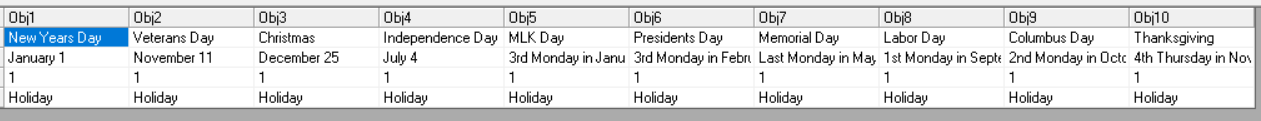

In [ ]:
unique_count = Can_holidays['holiday_name'].nunique()
unique_names = Can_holidays['holiday_name'].unique()
# Print the number of unique names
print('Number of unique names:', unique_count)
print(unique_names)

Number of unique names: 14
["New Year's Day" None 'Martin Luther King Jr. Day'
 "Washington's Birthday" 'Memorial Day' 'Independence Day'
 'Independence Day (Observed)' 'Labor Day' 'Columbus Day' 'Veterans Day'
 'Thanksgiving' 'Christmas Day (Observed)' 'Christmas Day'
 "New Year's Day (Observed)" 'Veterans Day (Observed)']


# Data Cleaning

In [ ]:
dfall = dfall.set_index('Date')

In [ ]:
#working_days = working_days.dropna(axis=0)

In [ ]:
dfall['Direct Normal Radiation']=pd.to_numeric(dfall['Direct Normal Radiation'].astype(str).str.strip())
dfall['Diffuse Horizontal Radiation']=pd.to_numeric(dfall['Diffuse Horizontal Radiation'].astype(str).str.strip())

In [ ]:
dfall['Heating'] = dfall['NaturalGasHVAC']+dfall['HeatingElectricity']
dfall = dfall.drop(['NaturalGasHVAC','HeatingElectricity','Cooling:Electricity'], axis = 1 )

In [ ]:
print(dfall.columns.get_loc('Heating'))
print(dfall.columns.get_loc('Dry Bulb Temperature'))
print(dfall.columns.get_loc('Occupancy Schedule'))

27
0
20


In [ ]:
dfall['Heating'] = dfall['Heating'] / (4979*1e3)
dfall['dayofw'] = dfall['dayofw'].astype(float)

In [ ]:
dfanalyze = dfall.iloc [: , [0 , 27,20]]

In [ ]:
dfanalyze

,Dry Bulb Temperature,Heating,Occupancy Schedule
Date,,,
2010-01-01 00:00:00+00:00,-21.6,56.920713,0.0
2010-01-01 01:00:00+00:00,-22.5,47.784959,0.0
2010-01-01 02:00:00+00:00,-23.8,62.083090,0.0
2010-01-01 03:00:00+00:00,-24.6,51.316413,0.0
2010-01-01 04:00:00+00:00,-25.6,65.447465,0.0
...,...,...,...
2019-12-31 18:00:00+00:00,-10.2,101.836077,0.0
2019-12-31 19:00:00+00:00,-10.4,103.093390,0.0
2019-12-31 20:00:00+00:00,-11.0,105.776174,0.0


<ipython-input-67-796f43c7a1c1>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfanalyze[col], ax=ax, kde=False, hist=True)


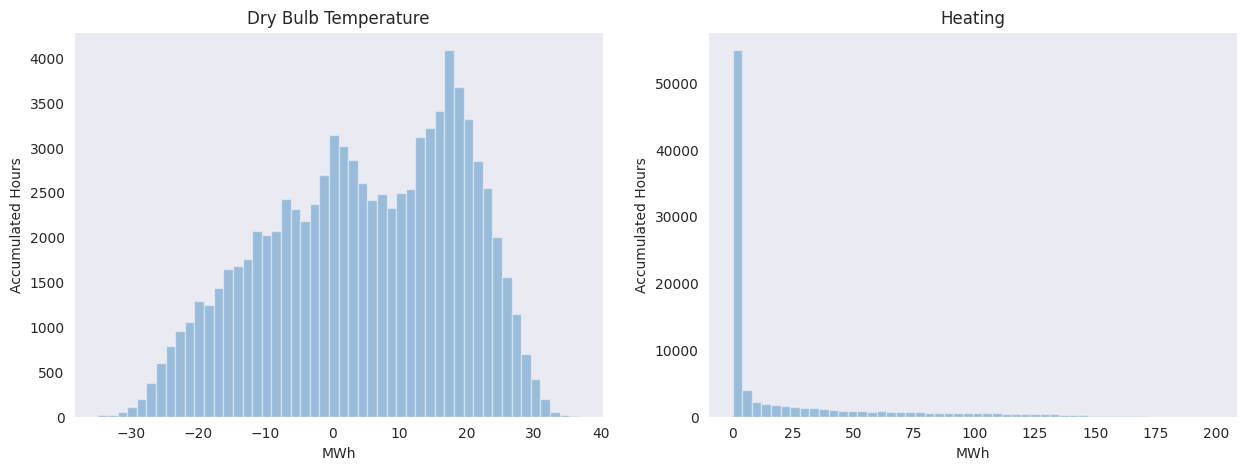

In [ ]:
#visualize the distributions

fig, axs = plt.subplots(1, 2, figsize=(15,5))

#cycle through subplots and columns
for ax, col in zip(axs, dfanalyze.columns):
    #histogram plot
    sns.distplot(dfanalyze[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title(col)
    ax.set_xlabel('MWh')
    ax.set_ylabel('Accumulated Hours')
    #set the y labels
    #ax.set_yticks(np.linspace(0, len(col), 10))
    
plt.show()

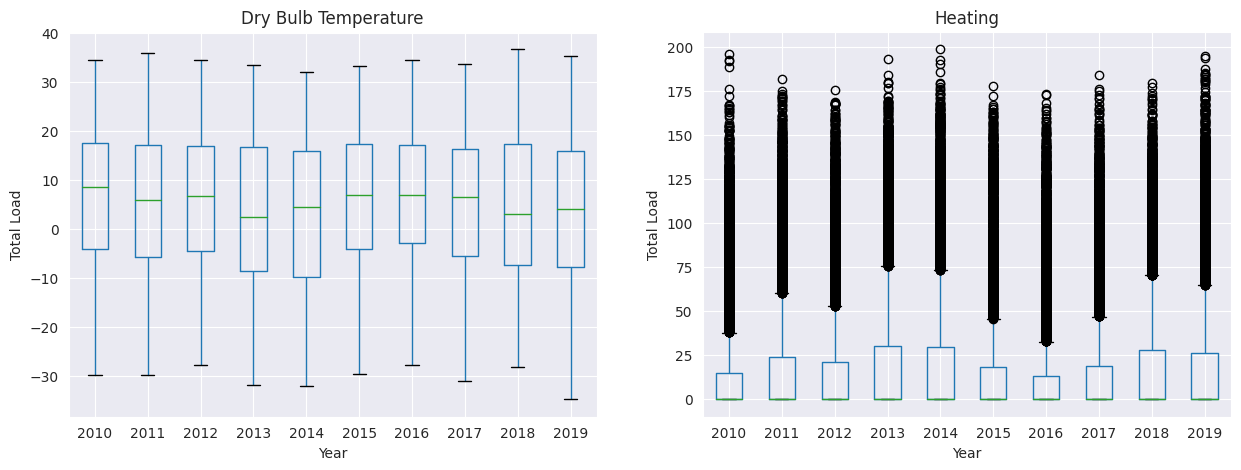

In [ ]:
#group the data into years for plotting

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, dfanalyze.columns):
    groups = dfanalyze[col].groupby(pd.Grouper(freq='A'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.year] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Load')
    ax.set_title(col)

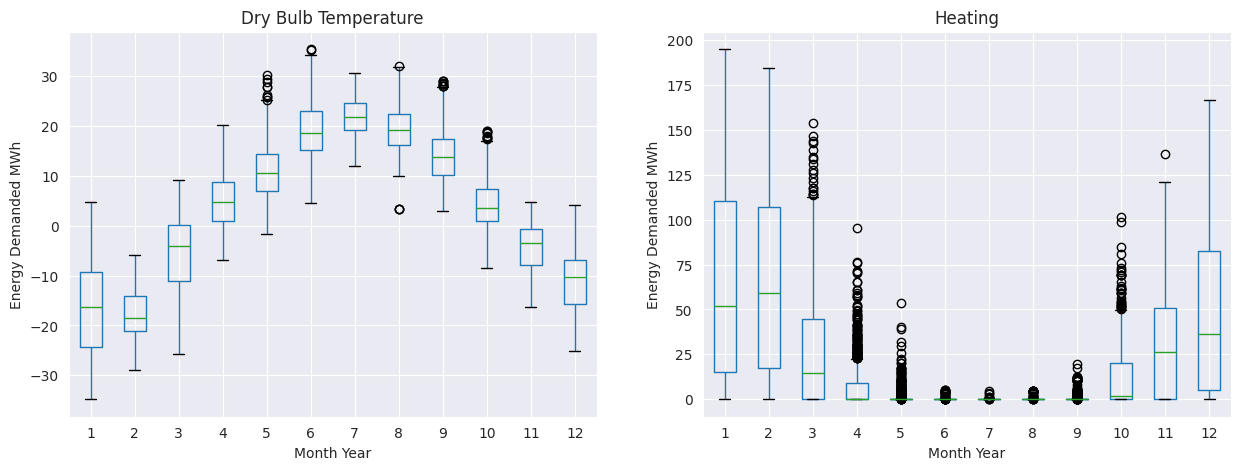

In [ ]:
### plot the monthly demand variability. Looking for seasonal effects

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, dfanalyze.columns):
    
    groups = dfanalyze[col].groupby(pd.Grouper(freq='M'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.month] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    

plt.show()

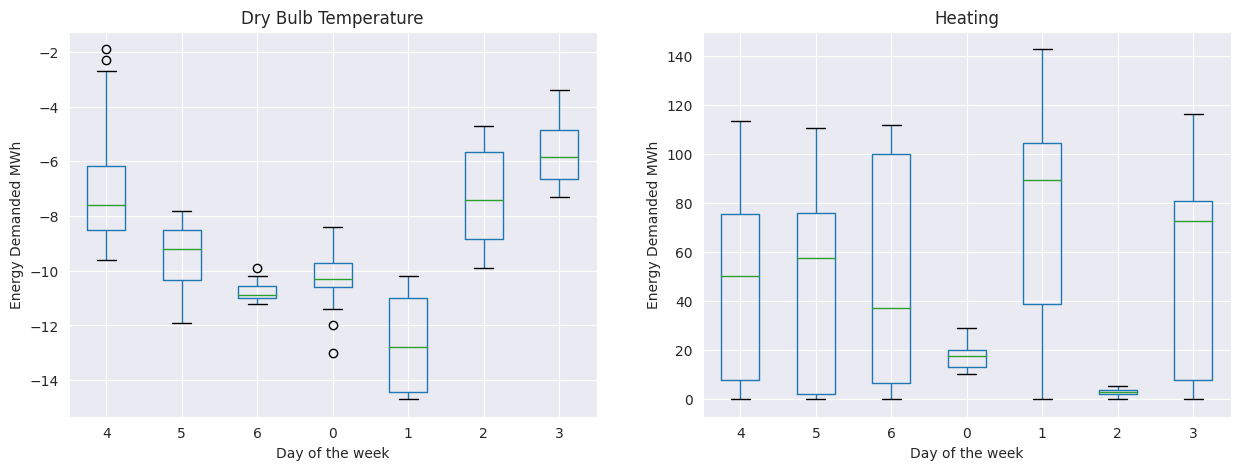

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, dfanalyze.columns):
    
    groups = dfanalyze[col].groupby(pd.Grouper(freq='D'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.dayofweek] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Day of the week')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

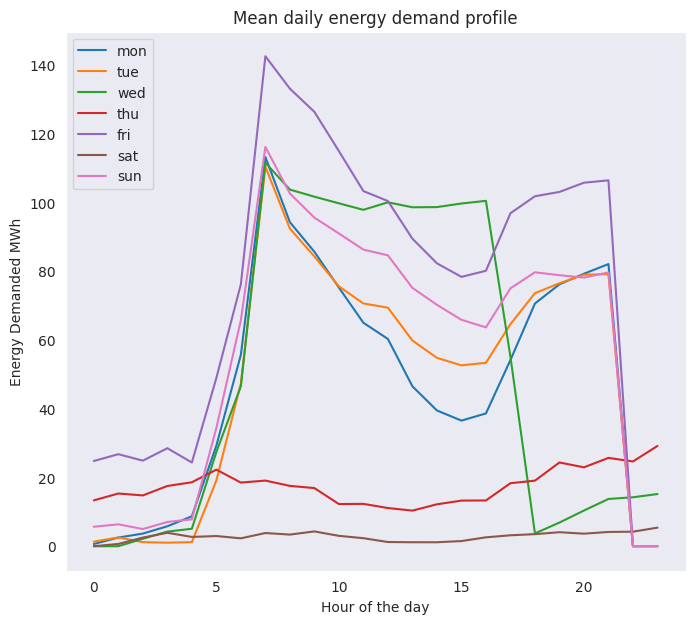

In [ ]:
group_hours = dfanalyze['Heating'].groupby(pd.Grouper(freq='D', how='mean'))

day_names = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()

for name, group in group_hours:
    df[name.dayofweek] = pd.Series(group.values)

df.columns = day_names
df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');

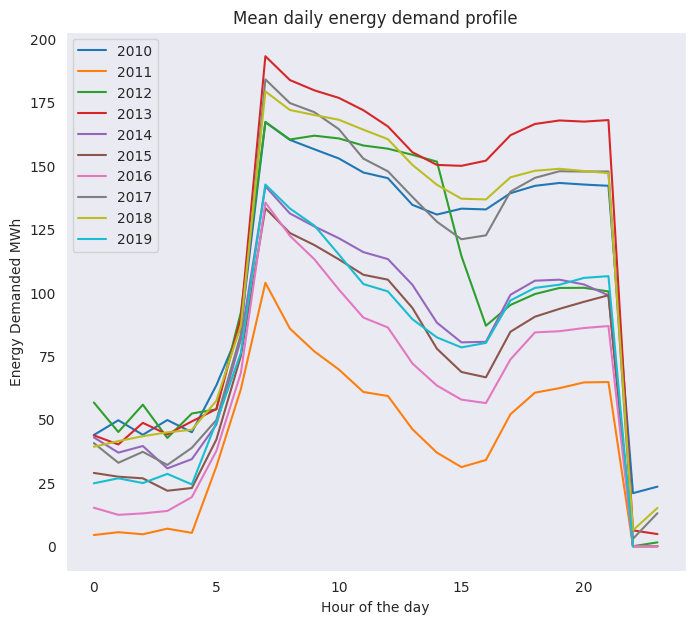

In [ ]:
group_hours = dfanalyze['Heating'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
for name, group in group_hours:
    df[name.year] = pd.Series(group.values)

df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');


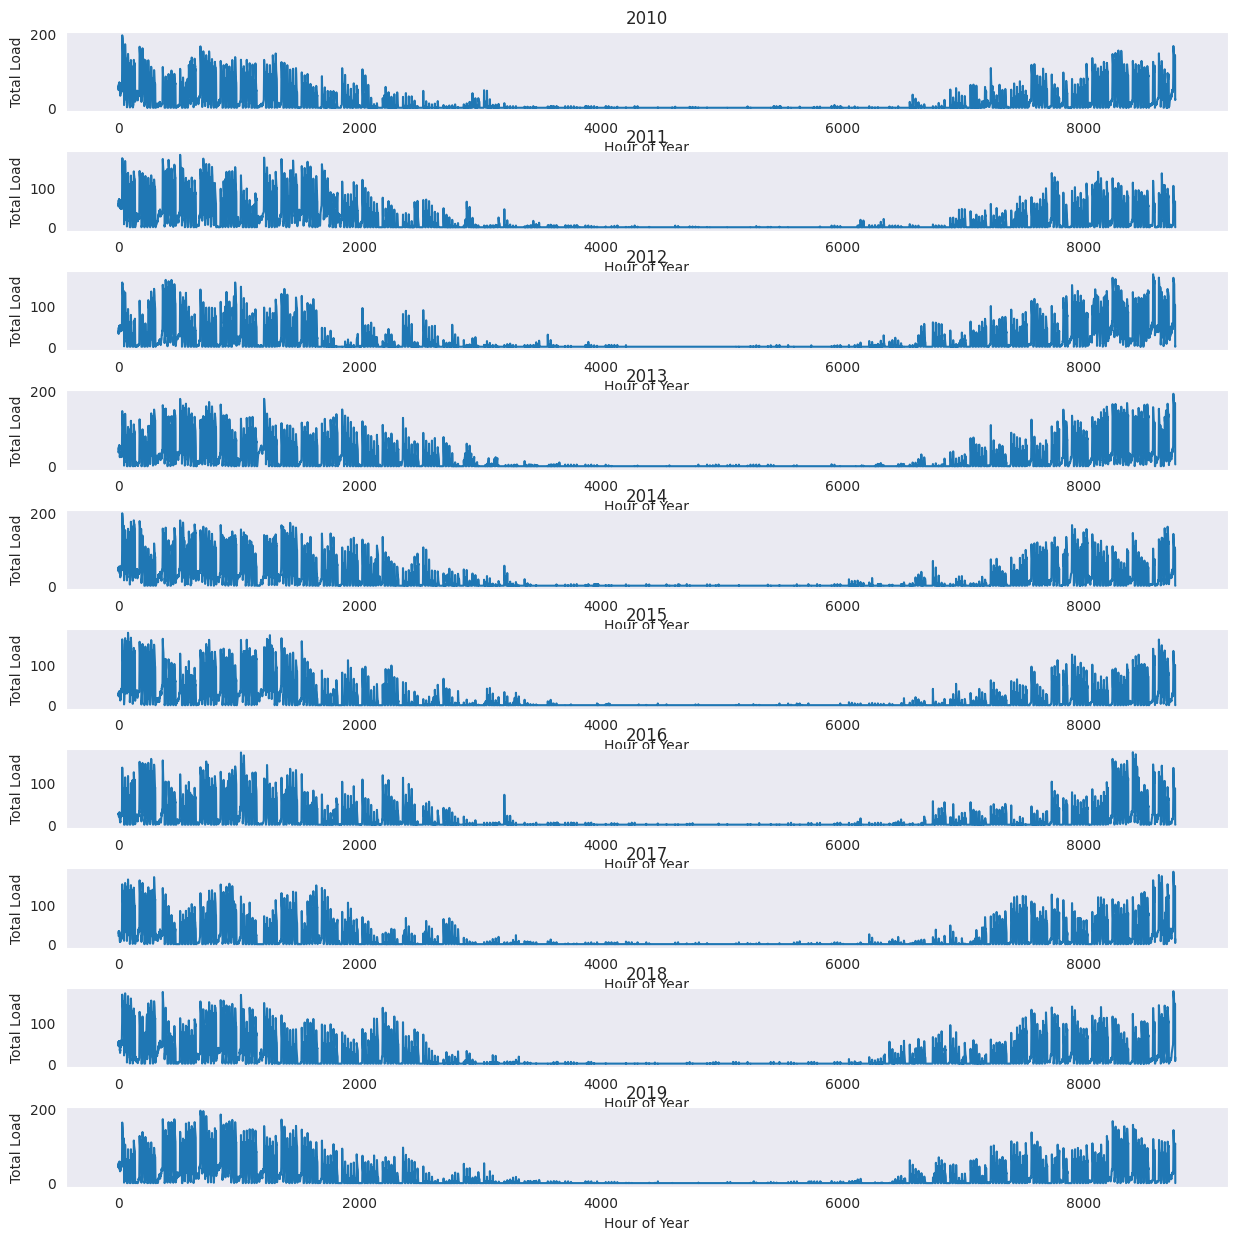

In [ ]:
##### Plot the yearly actual loads

#group data by year
groups =  dfanalyze['Heating'].groupby(pd.Grouper(freq='A'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=0.5)

In [ ]:
#import package to transform energy data to hourly slices
from features_preprocessing import transform_to_windows

In [ ]:
#transform data and have a look.
hourly_slices = transform_to_windows(dfanalyze, 'Heating')

#drop 2019 data
hourly_slices = hourly_slices[:'2019']
hourly_slices.tail()

/content/features_preprocessing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data.index.year
/content/features_preprocessing.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data.index.month
/content/features_preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

hours,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-27,0.646171,2.518765,3.679512,5.805961,8.703999,29.266017,55.723542,113.241624,94.298420,85.676190,75.264307,65.018456,60.314202,46.534514,39.502549,36.553966,38.634935,54.176582,70.627424,76.210400,79.291694,82.103961,0.000000,0.000000
2019-12-28,1.327122,2.562212,1.188113,1.026492,1.187266,19.150550,47.354577,110.449794,92.410106,84.306476,75.618021,70.638392,69.409945,59.860573,54.811422,52.628433,53.383598,64.607407,73.638142,76.516266,79.002401,79.161069,0.000000,0.000000
2019-12-29,0.000000,0.000000,2.177505,4.247676,5.083805,27.421174,46.550421,111.592981,103.777653,101.707241,99.780905,97.886187,100.073313,98.628328,98.682015,99.727653,100.501300,55.131112,3.723793,6.885157,10.383242,13.753041,14.244400,15.191280
2019-12-30,13.344244,15.334971,14.784444,17.527917,18.610157,22.279239,18.520179,19.100486,17.556125,16.917241,12.271821,12.322909,11.111725,10.360475,12.199217,13.275061,13.314191,18.339327,19.080887,24.370086,22.954802,25.703958,24.658592,29.189606
2019-12-31,24.802902,26.777868,24.897259,28.517449,24.361668,48.962558,76.216282,142.582396,133.148343,126.397408,114.973542,103.338225,100.444240,89.486189,82.324230,78.375230,80.145869,96.889679,101.836077,103.093390,105.776174,106.468474,0.000000,NaN


<ipython-input-76-fe137f8abd45>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hourly_slices[col], ax=ax, kde=False, hist=True)


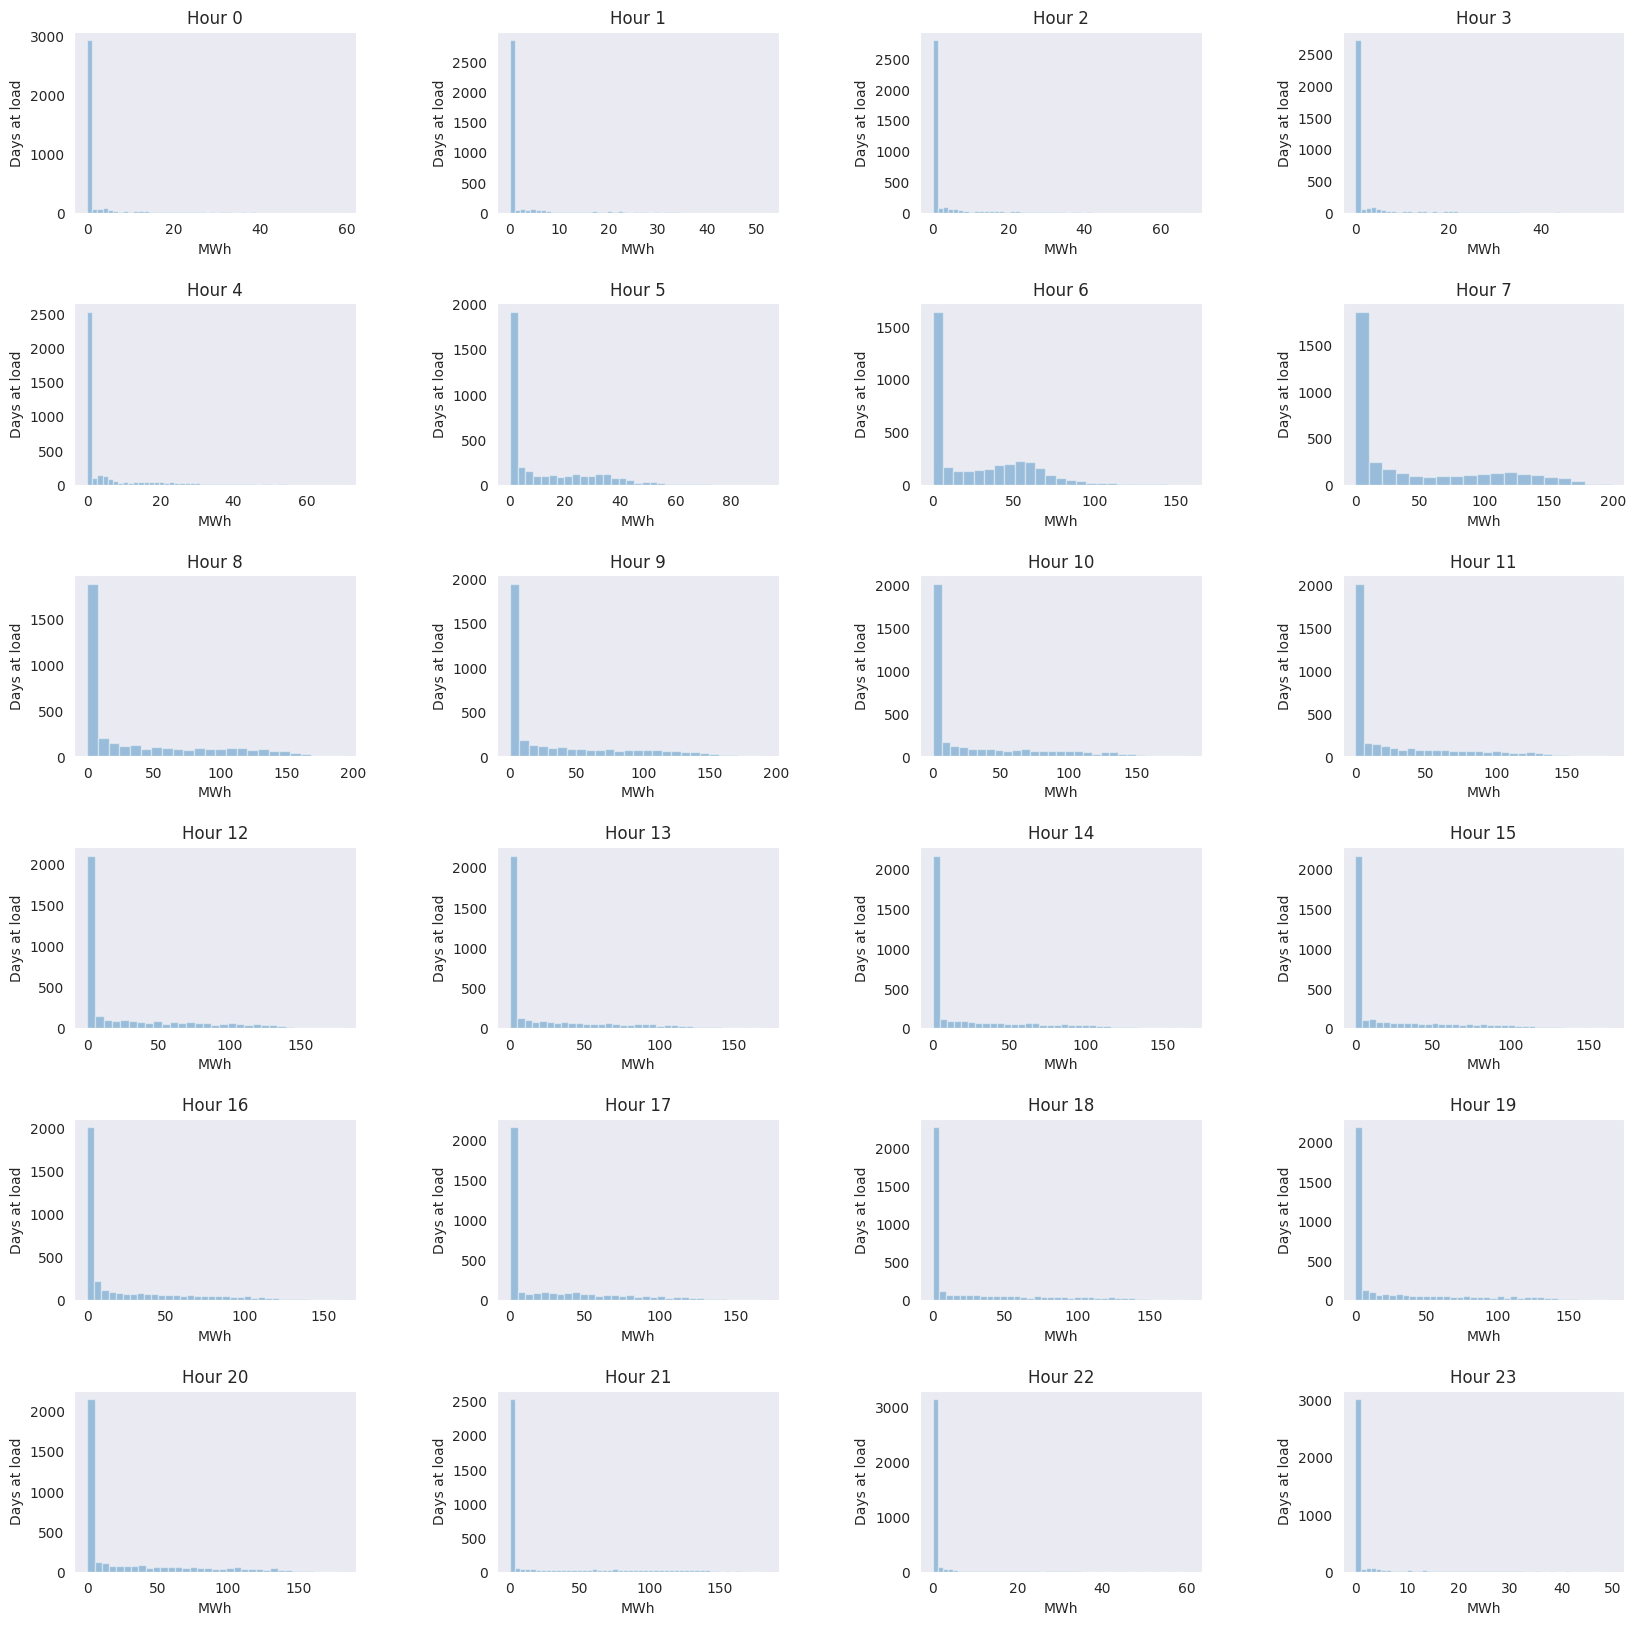

In [ ]:
fig, axs = plt.subplots(6, 4, figsize=(20,20))

#cycle through subplots and columns
for ax, col in zip(axs.flatten(), hourly_slices.columns):
    #histogram plot
    sns.distplot(hourly_slices[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title('Hour ' + str(col))
    ax.set_xlabel('MWh')
    ax.set_ylabel('Days at load')
    #set the y labels
    #ax.set_yticks(np.linspace(0, 2000, 9))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plt.show()

# Filtering Data

In [ ]:
# dfall = dfall[ ~((dfall['months'] > 4) & (dfall['months'] < 10))]

In [ ]:
new_names1 = {col: col.replace(' ', '') for col in dfall.columns}
dfall = dfall.rename(columns=new_names1)

In [ ]:
whole_data = dfall

In [ ]:
df_filtered_weekends_holidays = dfall[((dfall['holiday_bool'] == True) | (dfall['dayofw'] > 4))]

In [ ]:
A = df_filtered_weekends_holidays
unique_count = A['dayofw'].nunique()
unique_names = A['dayofw'].unique()
# Print the number of unique names
print('Number of unique names:', unique_count)
print(unique_names)

Number of unique names: 7
[4. 5. 6. 0. 1. 3. 2.]


In [ ]:
#working_days = dfall[ ((dfall['holiday_bool'] == False) | (dfall['dayofw'] < 5))]
working_days = dfall[~((dfall['holiday_bool'] == True) | (dfall['dayofw'] > 4))]
unique_count = working_days['dayofw'].nunique()
unique_names = working_days['dayofw'].unique()
# Print the number of unique names
print('Number of unique names:', unique_count)
print(unique_names)

Number of unique names: 5
[0. 1. 2. 3. 4.]


In [ ]:
'''
B = working_days[((working_days['holiday_bool'] == False) & (working_days['dayofw'] > -1))]
unique_count = B['dayofw'].nunique()
unique_names = B['dayofw'].unique()
# Print the number of unique names
print('Number of unique names:', unique_count)
print(unique_names)
'''
'''
C = working_days[((working_days['holiday_bool'] == True) | (working_days['dayofw'] > 4))]
unique_count = C['dayofw'].nunique()
unique_names = C['dayofw'].unique()
# Print the number of unique names
print('Number of unique names:', unique_count)
print(unique_names)
'''

In [ ]:
#working_days = working_days.dropna(axis=0)

In [ ]:
'''
working_days['Direct Normal Radiation']=pd.to_numeric(working_days['Direct Normal Radiation'].astype(str).str.strip())
working_days['Diffuse Horizontal Radiation']=pd.to_numeric(working_days['Diffuse Horizontal Radiation'].astype(str).str.strip())
'''

In [ ]:
'''
working_days['Heating'] = working_days['NaturalGasHVAC']+working_days['HeatingElectricity']
working_days = working_days.drop(['NaturalGasHVAC','HeatingElectricity','Cooling:Electricity'], axis = 1 )
'''

In [ ]:
#working_days.info()

In [ ]:
#df_filtered_weekends_holidays.info()

In [ ]:
#df_filtered_weekends_holidays = df_filtered_weekends_holidays.dropna(axis=0)
'''
df_filtered_weekends_holidays['Direct Normal Radiation']=pd.to_numeric(df_filtered_weekends_holidays['Direct Normal Radiation'].astype(str).str.strip())
df_filtered_weekends_holidays['Diffuse Horizontal Radiation']=pd.to_numeric(df_filtered_weekends_holidays['Diffuse Horizontal Radiation'].astype(str).str.strip())
df_filtered_weekends_holidays['Heating'] = df_filtered_weekends_holidays['NaturalGasHVAC']+df_filtered_weekends_holidays['HeatingElectricity']
df_filtered_weekends_holidays = df_filtered_weekends_holidays.drop(['NaturalGasHVAC','HeatingElectricity','Cooling:Electricity'], axis = 1 )
df_filtered_weekends_holidays.info()
'''

# Prof Kavgic's Email:
* using the most extreme years, such as 2010 and 2014, with more medium, such as 2011 or 2017, for training and testing the model for the rest of the years. You can have different strategies, and the goal is to use the least data for training possible.
* you should analyze the energy patterns more closely and divide day in certain periods. For example, night-unoccupied hours, morning peak, midday, afternoon peak, and evening. That is to identify time of day-break points for dividing hourly energy consumption into periods for training models.

In [ ]:
print(len(working_days['Heating']))

60144


In [ ]:
# Dropping symmerdays
# raw_df[raw_df['Date'].between('2019-01-01', '2019-12-31')]

In [ ]:
#working_days = working_days[ ~((working_days['months'] > 4) & (working_days['months'] < 9))]
heating_months = working_days['months'].unique()
print(len(working_days['Heating']))
print(heating_months)

60144
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
night_unoccupied_hours = working_days[ (working_days['hours'] > 17) | ((working_days['hours'] > -1) & (working_days['hours'] < 6))]
unique_names_night = night_unoccupied_hours['hours'].unique()
print(len(night_unoccupied_hours['Heating']))
print(unique_names_night)

30072
[ 0  1  2  3  4  5 18 19 20 21 22 23]


In [ ]:
morning_peak = working_days[ ((working_days['hours'] > 5) & (working_days['hours'] < 10))]
unique_names_mp = morning_peak['hours'].unique()
print(len(morning_peak['Heating']))
print(unique_names_mp)

10024
[6 7 8 9]


In [ ]:
middy = working_days[ ((working_days['hours'] > 9) & (working_days['hours'] < 15))]
unique_names_mid = middy['hours'].unique()
print(unique_names_mid)
print(len(middy['Heating']))

[10 11 12 13 14]
12530


In [ ]:
afternoon = working_days[ ((working_days['hours'] > 14) & (working_days['hours'] < 18))]
unique_names_aft = afternoon['hours'].unique()
print(unique_names_aft)
print(len(afternoon['Heating']))

[15 16 17]
7518


# Saving the data

In [ ]:
# working_days = working_days.drop([ 'holiday_bool','Wind Direction', ''] , axis = 1)
'''
if working_days.isnull().any().any():
    print('There are null values in the DataFrame')
else:
    print('There are no null values in the DataFrame')
    '''

"\nif working_days.isnull().any().any():\n    print('There are null values in the DataFrame')\nelse:\n    print('There are no null values in the DataFrame')\n    "

In [ ]:
null_counts = working_days.isnull().sum()
non_null_counts = len(working_days) - null_counts

print('Null Counts:\n', null_counts)
print('\nNon-Null Counts:\n', non_null_counts)

Null Counts:
 DryBulbTemperature                                 0
DewPointTemperature                                0
RelativeHumidity                                   0
AtmosphericPressure                                0
ExtraterrestrialHorizontalRadiation                0
ExtraterrestrialDirectNormalRadiation              0
HorizontalInfraredRadiationIntensityfromSky        0
GlobalHorizontalRadiation                          0
DirectNormalRadiation                              0
DiffuseHorizontalRadiation                         0
GlobalHorizontalIlluminance                        0
DirectNormalIlluminance                            0
DiffuseHorizontalIlluminance                       0
WindDirection                                      0
WindSpeed                                          0
TotalSkyCover                                      0
OpaqueSkyCover                                     0
PrecipitableWater                                  0
AerosolOpticalDepth             

In [ ]:
heating_values = working_days['Heating'].unique()
print(len(heating_values))

26919


In [ ]:
df_filtered_weekends_holidays

,DryBulbTemperature,DewPointTemperature,RelativeHumidity,AtmosphericPressure,ExtraterrestrialHorizontalRadiation,ExtraterrestrialDirectNormalRadiation,HorizontalInfraredRadiationIntensityfromSky,GlobalHorizontalRadiation,DirectNormalRadiation,DiffuseHorizontalRadiation,GlobalHorizontalIlluminance,DirectNormalIlluminance,DiffuseHorizontalIlluminance,WindDirection,WindSpeed,TotalSkyCover,OpaqueSkyCover,PrecipitableWater,AerosolOpticalDepth,SnowDepth,OccupancySchedule,hours,dayofw,months,datee,holiday_bool,holiday_name,Heating
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,-21.6,-25.4,71.0,100230.0,0.0,9999,177.240384,0.0,0.0,0.0,0.0,0.0,0.0,34.0,9.0,0.0,8.0,0.0,0.0,0.0,0.00,0,4.0,1,2010-01-01,True,New Year's Day,56.920713
2010-01-01 01:00:00+00:00,-22.5,-26.0,73.0,100310.0,0.0,9999,174.261326,0.0,0.0,0.0,0.0,0.0,0.0,35.0,11.0,6.0,8.0,0.0,0.0,0.0,0.00,1,4.0,1,2010-01-01,True,New Year's Day,47.784959
2010-01-01 02:00:00+00:00,-23.8,-27.5,71.0,100390.0,0.0,9999,157.302450,0.0,0.0,0.0,0.0,0.0,0.0,34.0,13.0,4.0,1.0,0.0,0.0,0.0,0.00,2,4.0,1,2010-01-01,True,New Year's Day,62.083090
2010-01-01 03:00:00+00:00,-24.6,-28.1,73.0,100510.0,0.0,9999,166.944016,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,0.0,8.0,0.0,0.0,0.0,0.00,3,4.0,1,2010-01-01,True,New Year's Day,51.316413
2010-01-01 04:00:00+00:00,-25.6,-29.1,72.0,100610.0,0.0,9999,163.542481,0.0,0.0,0.0,0.0,0.0,0.0,33.0,11.0,4.0,8.0,0.0,0.0,0.0,0.00,4,4.0,1,2010-01-01,True,New Year's Day,65.447465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29 19:00:00+00:00,-10.4,-12.3,86.0,98430.0,0.0,9999,219.175053,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,8.0,7.0,0.0,0.0,1.0,0.10,19,6.0,12,2019-12-29,False,None,6.885157
2019-12-29 20:00:00+00:00,-10.3,-12.1,86.0,98390.0,0.0,9999,219.680170,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,9.0,7.0,0.0,0.0,1.0,0.10,20,6.0,12,2019-12-29,False,None,10.383242
2019-12-29 21:00:00+00:00,-10.2,-12.0,87.0,98390.0,0.0,9999,217.564313,0.0,0.0,0.0,0.0,0.0,0.0,35.0,16.0,9.0,6.0,0.0,0.0,1.0,0.10,21,6.0,12,2019-12-29,False,None,13.753041


In [ ]:
df_filtered_weekends_holidays.reset_index(drop=False, inplace=True)
working_days.reset_index(drop=False, inplace=True)
night_unoccupied_hours.reset_index(drop=False, inplace=True)
morning_peak.reset_index(drop=False, inplace=True)
middy.reset_index(drop=False, inplace=True)
afternoon.reset_index(drop=False, inplace=True)

In [ ]:
%cd /content/saj/MyDrive/Kavgic/DataReadyForModels/withsummer
df_filtered_weekends_holidays.to_csv('df_filtered_weekends_holidays.csv', index=False)
working_days.to_csv('working_days.csv', index=False)
night_unoccupied_hours.to_csv('night_unoccupied_hours.csv', index=False)
morning_peak.to_csv('morning_peak.csv', index=False)
middy.to_csv('middy.csv', index=False)
afternoon.to_csv('afternoon.csv', index=False)

/content/saj/MyDrive/Kavgic/DataReadyForModels/withsummer


In [ ]:
afternoon.reset_index(drop=False, inplace=True)

In [ ]:
%cd /content/saj/MyDrive/Kavgic/DataReadyForModels/withsummer
whole_data.to_csv('whole_data.csv', index=False)

/content/saj/MyDrive/Kavgic/DataReadyForModels/withsummer


# Feature selection techniques

# Adding historical data as new columns

In [ ]:
# Loading data 
def load_data(col=None,
              path='/content/saj/MyDrive/Kavgic/DataReadyForModels/withsummer/whole_data.csv', verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

multivar_df = load_data(['Dry Bulb Temperature','Direct Normal Radiation','dayofw','Snow Depth','Occupancy Schedule','Heating'], verbose = True )


   Dry Bulb Temperature  Direct Normal Radiation  dayofw  Snow Depth  \
0                 -21.6                      0.0       4         0.0   
1                 -22.5                      0.0       4         0.0   
2                 -23.8                      0.0       4         0.0   
3                 -24.6                      0.0       4         0.0   
4                 -25.6                      0.0       4         0.0   

   Occupancy Schedule       Heating  
0                 0.0  2.834082e+08  
1                 0.0  2.379213e+08  
2                 0.0  3.091117e+08  
3                 0.0  2.555044e+08  
4                 0.0  3.258629e+08  


In [ ]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=48 , n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('heatTime%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('heatTime%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('heatTime%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

multivar_df = [x for x in multivar_df['Heating']]
histdata_w = series_to_supervised(multivar_df)
#data_worrkingdays

In [ ]:
pearsoncorr_workingdays = histdata_w.corr(method = 'pearson')
# pearsoncorr

In [ ]:
import seaborn as seabornInstance

In [ ]:
histdata_w

,heatTime1(t-48),heatTime1(t-47),heatTime1(t-46),heatTime1(t-45),heatTime1(t-44),heatTime1(t-43),heatTime1(t-42),heatTime1(t-41),heatTime1(t-40),heatTime1(t-39),heatTime1(t-38),heatTime1(t-37),heatTime1(t-36),heatTime1(t-35),heatTime1(t-34),heatTime1(t-33),heatTime1(t-32),heatTime1(t-31),heatTime1(t-30),heatTime1(t-29),heatTime1(t-28),heatTime1(t-27),heatTime1(t-26),heatTime1(t-25),heatTime1(t-24),heatTime1(t-23),heatTime1(t-22),heatTime1(t-21),heatTime1(t-20),heatTime1(t-19),heatTime1(t-18),heatTime1(t-17),heatTime1(t-16),heatTime1(t-15),heatTime1(t-14),heatTime1(t-13),heatTime1(t-12),heatTime1(t-11),heatTime1(t-10),heatTime1(t-9),heatTime1(t-8),heatTime1(t-7),heatTime1(t-6),heatTime1(t-5),heatTime1(t-4),heatTime1(t-3),heatTime1(t-2),heatTime1(t-1),heatTime1(t)
48,2.834082e+08,2.379213e+08,3.091117e+08,2.555044e+08,3.258629e+08,2.653920e+08,3.406289e+08,2.726327e+08,3.388247e+08,2.667912e+08,3.264003e+08,2.401629e+08,2.653690e+08,1.831893e+08,2.134453e+08,1.617613e+08,2.186352e+08,2.021300e+08,2.666935e+08,2.222056e+08,2.843966e+08,2.271736e+08,2.740258e+08,2.211755e+08,2.811609e+08,2.205828e+08,2.760740e+08,2.162716e+08,2.700688e+08,3.157374e+08,4.862126e+08,9.764804e+08,9.583871e+08,9.566655e+08,9.378002e+08,8.774823e+08,8.323757e+08,771298214.3,727349824.3,695248716.5,688105464.8,765601238.8,8.126853e+08,8.102218e+08,8.158855e+08,8.192238e+08,3.642169e+07,7.682910e+07,7.661644e+07
49,2.379213e+08,3.091117e+08,2.555044e+08,3.258629e+08,2.653920e+08,3.406289e+08,2.726327e+08,3.388247e+08,2.667912e+08,3.264003e+08,2.401629e+08,2.653690e+08,1.831893e+08,2.134453e+08,1.617613e+08,2.186352e+08,2.021300e+08,2.666935e+08,2.222056e+08,2.843966e+08,2.271736e+08,2.740258e+08,2.211755e+08,2.811609e+08,2.205828e+08,2.760740e+08,2.162716e+08,2.700688e+08,3.157374e+08,4.862126e+08,9.764804e+08,9.583871e+08,9.566655e+08,9.378002e+08,8.774823e+08,8.323757e+08,7.712982e+08,727349824.3,695248716.5,688105464.8,765601238.8,812685298.2,8.102218e+08,8.158855e+08,8.192238e+08,3.642169e+07,7.682910e+07,7.661644e+07,1.131934e+08
50,3.091117e+08,2.555044e+08,3.258629e+08,2.653920e+08,3.406289e+08,2.726327e+08,3.388247e+08,2.667912e+08,3.264003e+08,2.401629e+08,2.653690e+08,1.831893e+08,2.134453e+08,1.617613e+08,2.186352e+08,2.021300e+08,2.666935e+08,2.222056e+08,2.843966e+08,2.271736e+08,2.740258e+08,2.211755e+08,2.811609e+08,2.205828e+08,2.760740e+08,2.162716e+08,2.700688e+08,3.157374e+08,4.862126e+08,9.764804e+08,9.583871e+08,9.566655e+08,9.378002e+08,8.774823e+08,8.323757e+08,7.712982e+08,7.273498e+08,695248716.5,688105464.8,765601238.8,812685298.2,810221776.6,8.158855e+08,8.192238e+08,3.642169e+07,7.682910e+07,7.661644e+07,1.131934e+08,1.289065e+08
51,2.555044e+08,3.258629e+08,2.653920e+08,3.406289e+08,2.726327e+08,3.388247e+08,2.667912e+08,3.264003e+08,2.401629e+08,2.653690e+08,1.831893e+08,2.134453e+08,1.617613e+08,2.186352e+08,2.021300e+08,2.666935e+08,2.222056e+08,2.843966e+08,2.271736e+08,2.740258e+08,2.211755e+08,2.811609e+08,2.205828e+08,2.760740e+08,2.162716e+08,2.700688e+08,3.157374e+08,4.862126e+08,9.764804e+08,9.583871e+08,9.566655e+08,9.378002e+08,8.774823e+08,8.323757e+08,7.712982e+08,7.273498e+08,6.952487e+08,688105464.8,765601238.8,812685298.2,810221776.6,815885520.7,8.192238e+08,3.642169e+07,7.682910e+07,7.661644e+07,1.131934e+08,1.289065e+08,1.356583e+08
52,3.258629e+08,2.653920e+08,3.406289e+08,2.726327e+08,3.388247e+08,2.667912e+08,3.264003e+08,2.401629e+08,2.653690e+08,1.831893e+08,2.134453e+08,1.617613e+08,2.186352e+08,2.021300e+08,2.666935e+08,2.222056e+08,2.843966e+08,2.271736e+08,2.740258e+08,2.211755e+08,2.811609e+08,2.205828e+08,2.760740e+08,2.162716e+08,2.700688e+08,3.157374e+08,4.862126e+08,9.764804e+08,9.583871e+08,9.566655e+08,9.378002e+08,8.774823e+08,8.323757e+08,7.712982e+08,7.273498e+08,6.952487e+08,6.881055e+08,765601238.8,812685298.2,810221776.6,815885520.7,819223760.7,3.642169e+07,7.682910e+07,7.661644e+07,1.131934e+08,1.289065e+08,1.356583e+08,1.099077e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,

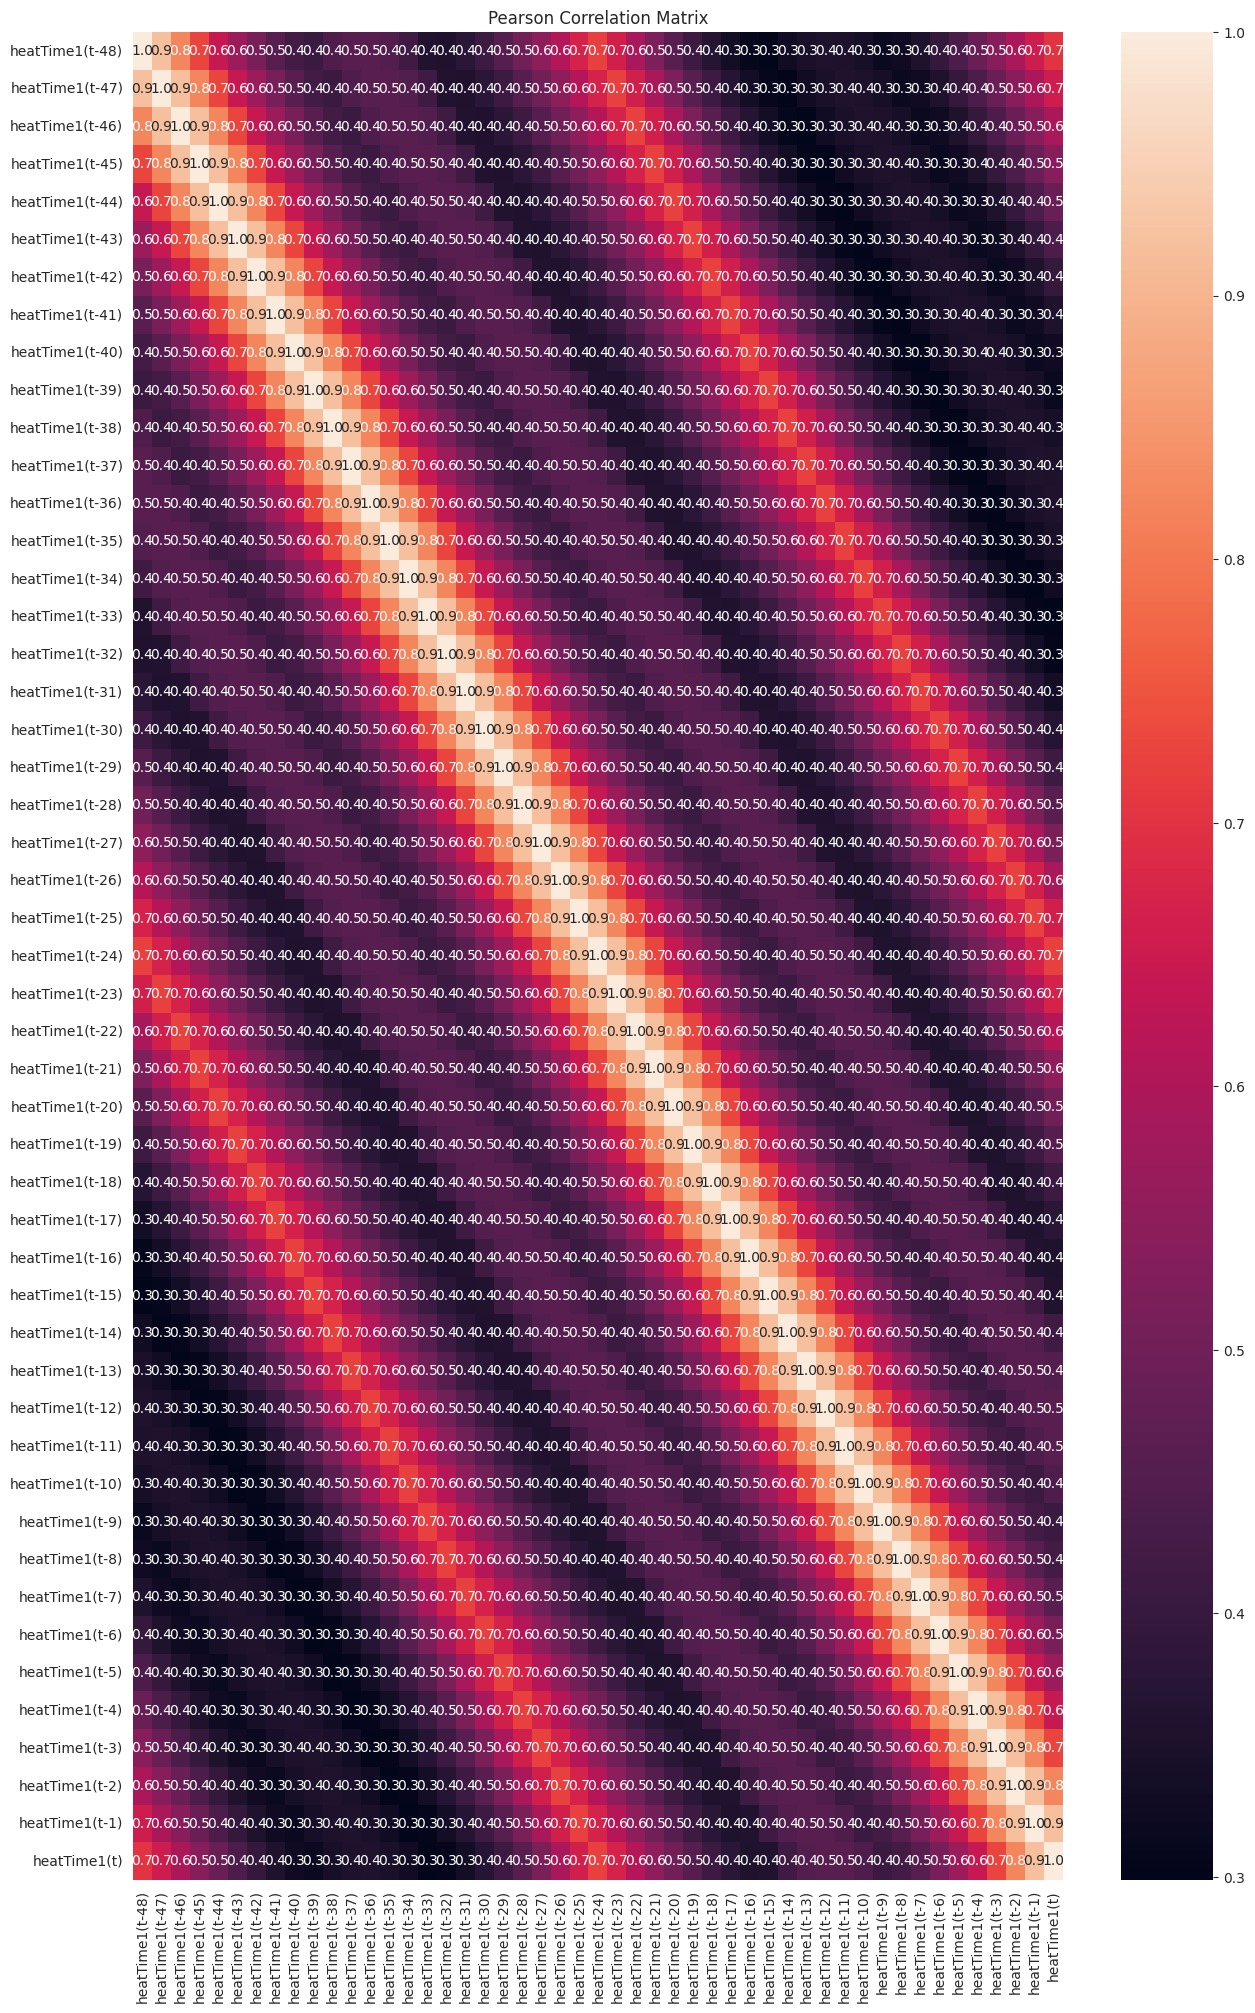

"\ncorr = data.corr()\nfig, ax=fig, ax = plt.subplots(figsize= (20,30))\ncax = ax.matshow(corr,cmap='Blues', vmin=-1, vmax=1)\nseabornInstance.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='Blues', annot=False, linewidth= 0.5 )\nplt.xticks(rotation=85)\n"

In [ ]:
# Plot Pearson correlation matrix

#correlations = data.corr(method='pearson')
fig = plt.figure(figsize=(15, 24))
sns.heatmap(pearsoncorr_workingdays, annot=True, fmt='.1f')
plt.title('Pearson Correlation Matrix')
plt.show()

'''
corr = data.corr()
fig, ax=fig, ax = plt.subplots(figsize= (20,30))
cax = ax.matshow(corr,cmap='Blues', vmin=-1, vmax=1)
seabornInstance.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='Blues', annot=False, linewidth= 0.5 )
plt.xticks(rotation=85)
'''

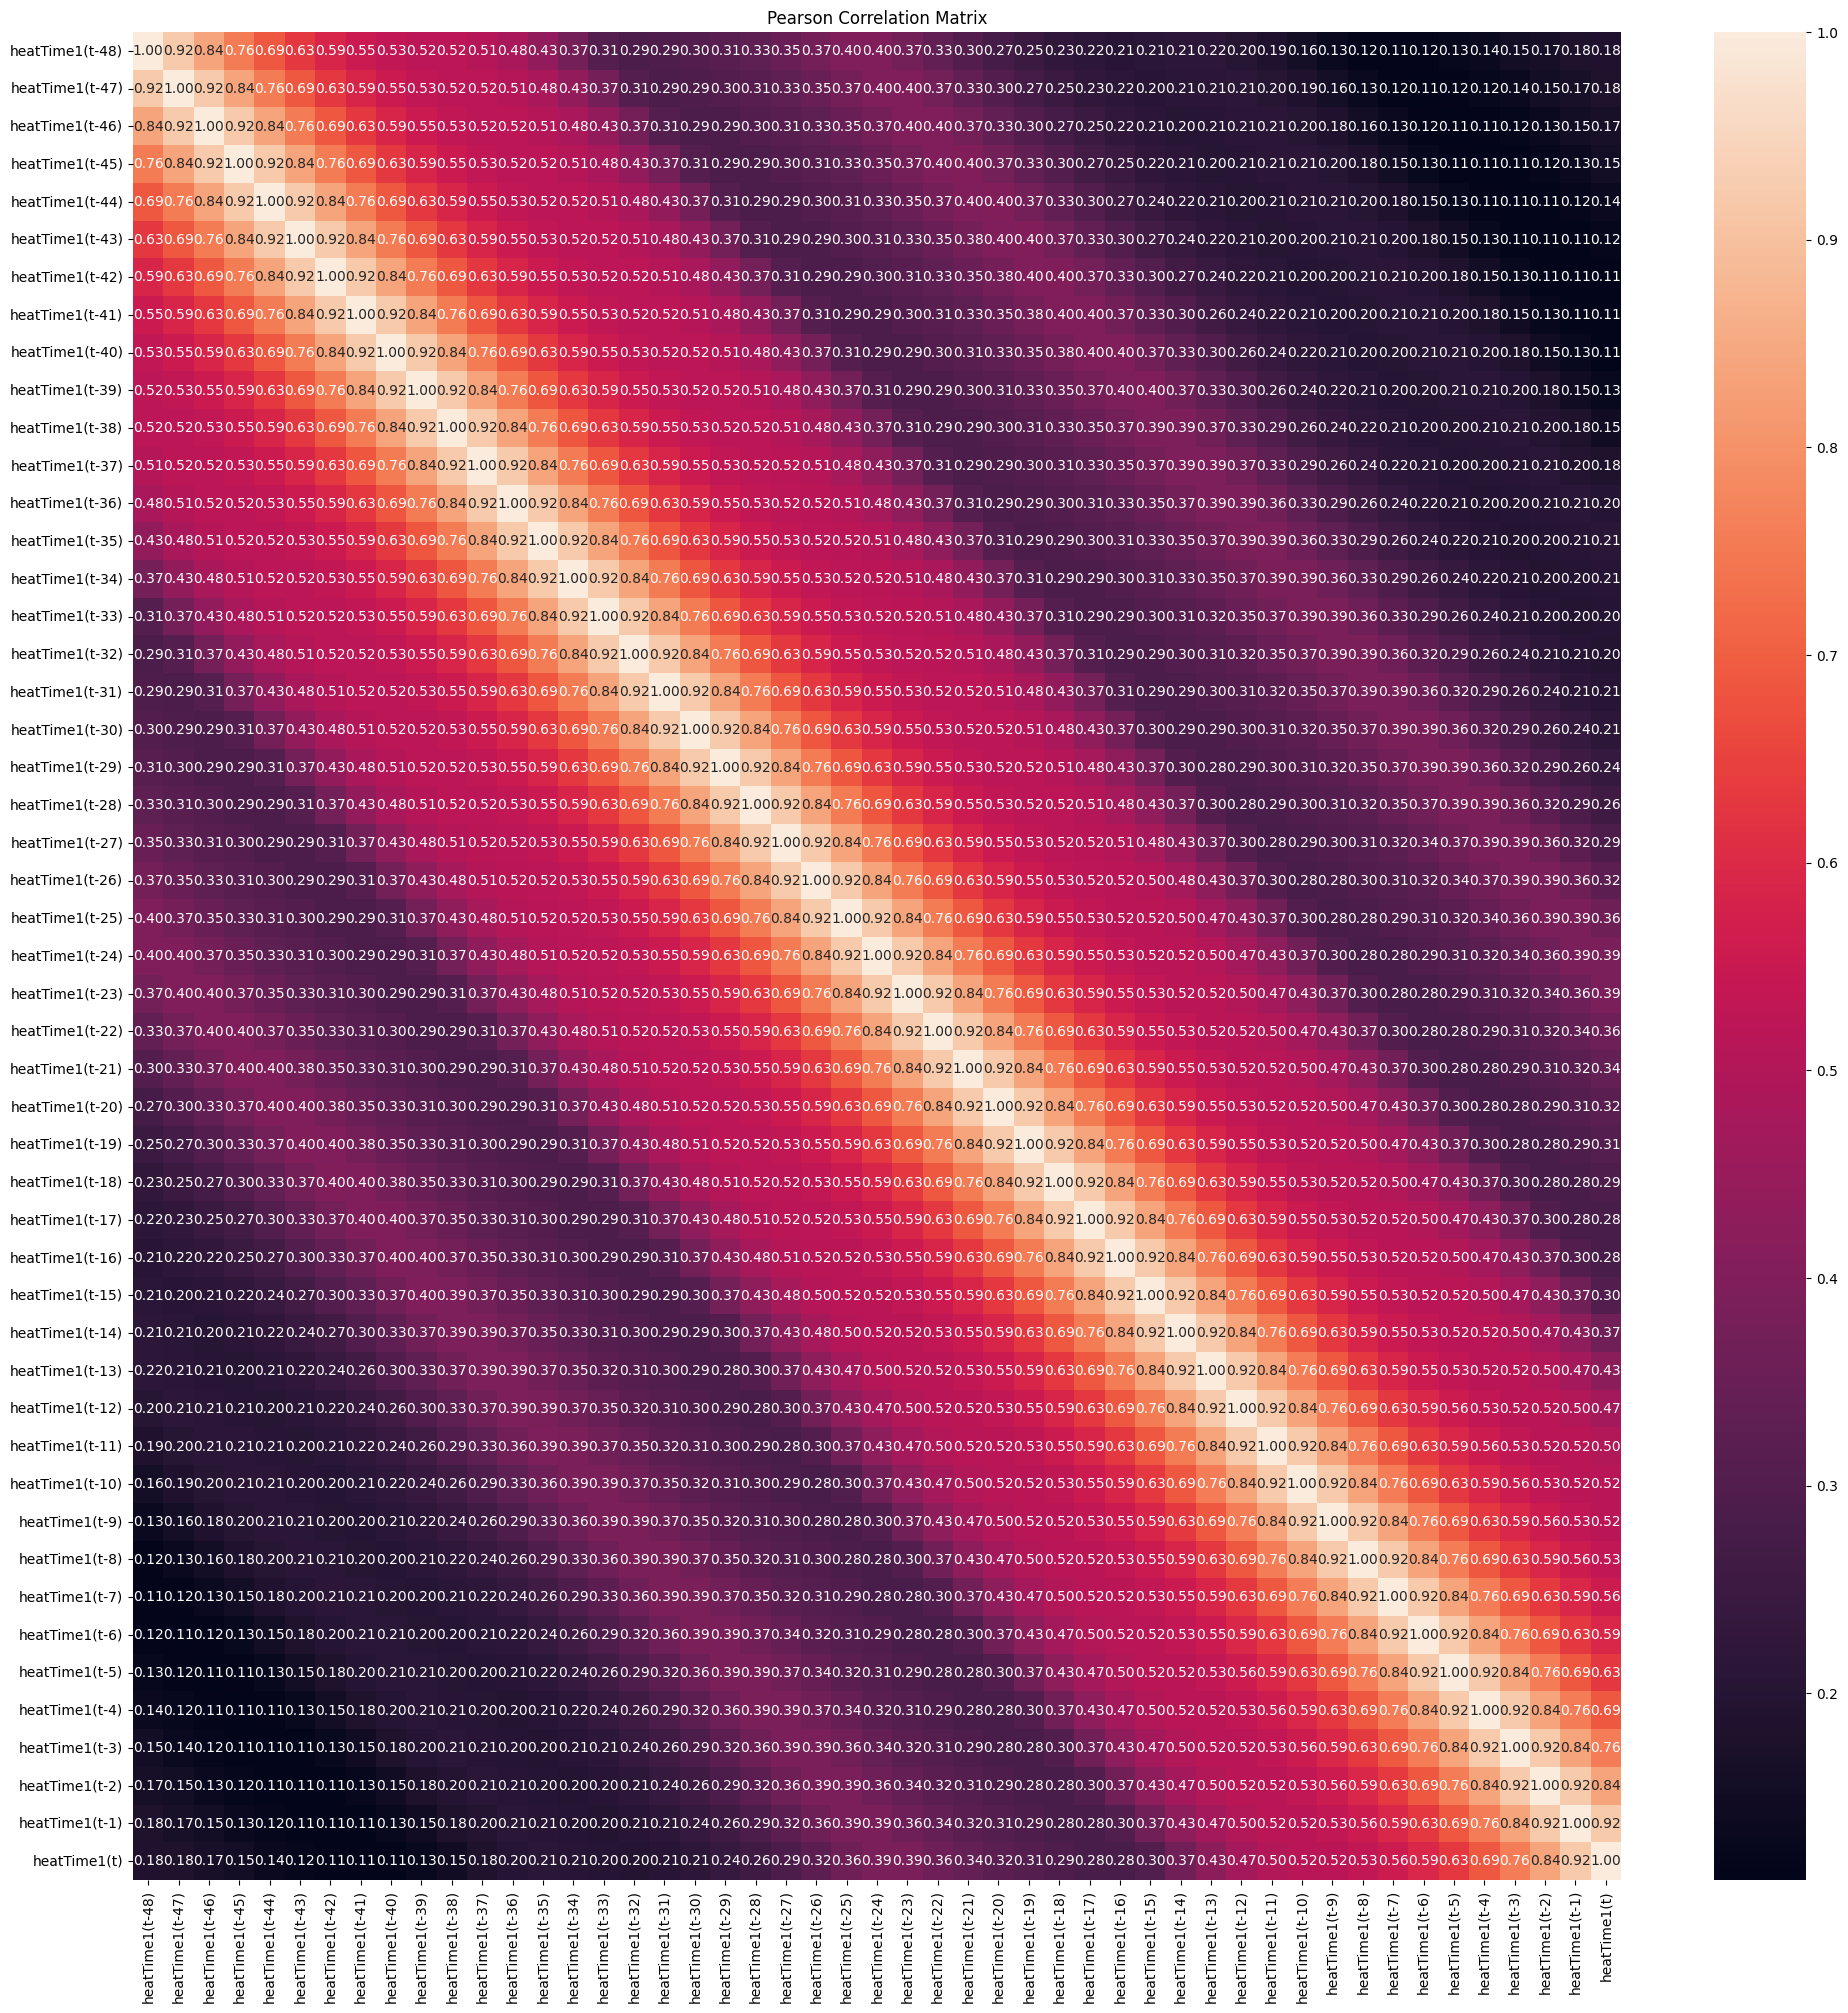

In [ ]:
# holidays
values_holydays  = [x for x in df_filtered_weekends_holidays['Heating']]
histdata_holydays = series_to_supervised(values_holydays)
#data_worrkingdays
pearsoncorr_holydays = histdata_holydays.corr(method = 'pearson')
# pearsoncorr
# Plot Pearson correlation matrix
#correlations = data.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(pearsoncorr_holydays, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

# **2. Wrapper Methods** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)


- In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from the subset. The problem is essentially reduced to a search problem. These methods are usually computationally very expensive.

- Some common examples of wrapper methods are 

  - 1. Forward selection, 
  - 2. Backward elimination, 
  - 3. Exhaustive feature selection,
  - 4. Recursive feature elimination.
  - 5. Recursive feature elimination with cross-validation
  
  
- Wrapper methods can be explained with the help of following graphic:

## **2.1 Forward Selection** <a class="anchor" id="3.1"></a>

[Table of Contents](#0.1) 


- Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

- The procedure starts with an empty set of features [reduced set]. The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set.

- Step forward feature selection starts by evaluating all features individually and selects the one that generates the best performing algorithm, according to a pre-set evaluation criteria. In the second step, it evaluates all possible combinations of the selected feature and a second feature, and selects the pair that produce the best performing algorithm based on the same pre-set criteria.

- The pre-set criteria can be the roc_auc for classification and the r squared for regression for example.

- This selection procedure is called greedy, because it evaluates all possible single, double, triple and so on feature combinations. Therefore, it is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.

- There is a special package for python that implements this type of feature selection: mlxtend.

- In the mlxtend implementation of the step forward feature selection, the stopping criteria is an arbitrarily set number of features. So the search will finish when we reach the desired number of selected features.


In [ ]:
# step forward feature selection
# histdata_worrkingdays
# histdata_holydays
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
histdata_worrkingdays

,heatTime1(t-48),heatTime1(t-47),heatTime1(t-46),heatTime1(t-45),heatTime1(t-44),heatTime1(t-43),heatTime1(t-42),heatTime1(t-41),heatTime1(t-40),heatTime1(t-39),heatTime1(t-38),heatTime1(t-37),heatTime1(t-36),heatTime1(t-35),heatTime1(t-34),heatTime1(t-33),heatTime1(t-32),heatTime1(t-31),heatTime1(t-30),heatTime1(t-29),heatTime1(t-28),heatTime1(t-27),heatTime1(t-26),heatTime1(t-25),heatTime1(t-24),heatTime1(t-23),heatTime1(t-22),heatTime1(t-21),heatTime1(t-20),heatTime1(t-19),heatTime1(t-18),heatTime1(t-17),heatTime1(t-16),heatTime1(t-15),heatTime1(t-14),heatTime1(t-13),heatTime1(t-12),heatTime1(t-11),heatTime1(t-10),heatTime1(t-9),heatTime1(t-8),heatTime1(t-7),heatTime1(t-6),heatTime1(t-5),heatTime1(t-4),heatTime1(t-3),heatTime1(t-2),heatTime1(t-1),heatTime1(t)
48,2.303802e+07,3.091053e+07,3.382296e+07,5.524438e+07,7.154033e+07,1.841410e+08,3.271917e+08,7.257194e+08,6.405889e+08,6.204926e+08,6.043763e+08,5.847050e+08,5.844722e+08,5.382476e+08,4.855797e+08,4.726458e+08,4.801840e+08,5.474075e+08,5.763368e+08,5.912785e+08,5.943114e+08,5.959685e+08,4.084834e+06,5.545856e+06,5.689769e+06,2.788856e+07,2.722612e+07,2.677731e+07,2.151305e+07,1.433342e+08,2.881204e+08,6.437007e+08,5.626815e+08,5.412845e+08,5.272871e+08,5.070285e+08,5.067375e+08,473138438.1,467581981.2,453190007.2,450217901.4,509193772.7,5.383420e+08,5.451216e+08,5.495388e+08,5.549723e+08,4.375195e+06,4.873834e+06,5.170818e+06
49,3.091053e+07,3.382296e+07,5.524438e+07,7.154033e+07,1.841410e+08,3.271917e+08,7.257194e+08,6.405889e+08,6.204926e+08,6.043763e+08,5.847050e+08,5.844722e+08,5.382476e+08,4.855797e+08,4.726458e+08,4.801840e+08,5.474075e+08,5.763368e+08,5.912785e+08,5.943114e+08,5.959685e+08,4.084834e+06,5.545856e+06,5.689769e+06,2.788856e+07,2.722612e+07,2.677731e+07,2.151305e+07,1.433342e+08,2.881204e+08,6.437007e+08,5.626815e+08,5.412845e+08,5.272871e+08,5.070285e+08,5.067375e+08,4.731384e+08,467581981.2,453190007.2,450217901.4,509193772.7,538342008.5,5.451216e+08,5.495388e+08,5.549723e+08,4.375195e+06,4.873834e+06,5.170818e+06,2.377130e+07
50,3.382296e+07,5.524438e+07,7.154033e+07,1.841410e+08,3.271917e+08,7.257194e+08,6.405889e+08,6.204926e+08,6.043763e+08,5.847050e+08,5.844722e+08,5.382476e+08,4.855797e+08,4.726458e+08,4.801840e+08,5.474075e+08,5.763368e+08,5.912785e+08,5.943114e+08,5.959685e+08,4.084834e+06,5.545856e+06,5.689769e+06,2.788856e+07,2.722612e+07,2.677731e+07,2.151305e+07,1.433342e+08,2.881204e+08,6.437007e+08,5.626815e+08,5.412845e+08,5.272871e+08,5.070285e+08,5.067375e+08,4.731384e+08,4.675820e+08,453190007.2,450217901.4,509193772.7,538342008.5,545121567.3,5.495388e+08,5.549723e+08,4.375195e+06,4.873834e+06,5.170818e+06,2.377130e+07,3.477833e+07
51,5.524438e+07,7.154033e+07,1.841410e+08,3.271917e+08,7.257194e+08,6.405889e+08,6.204926e+08,6.043763e+08,5.847050e+08,5.844722e+08,5.382476e+08,4.855797e+08,4.726458e+08,4.801840e+08,5.474075e+08,5.763368e+08,5.912785e+08,5.943114e+08,5.959685e+08,4.084834e+06,5.545856e+06,5.689769e+06,2.788856e+07,2.722612e+07,2.677731e+07,2.151305e+07,1.433342e+08,2.881204e+08,6.437007e+08,5.626815e+08,5.412845e+08,5.272871e+08,5.070285e+08,5.067375e+08,4.731384e+08,4.675820e+08,4.531900e+08,450217901.4,509193772.7,538342008.5,545121567.3,549538833.3,5.549723e+08,4.375195e+06,4.873834e+06,5.170818e+06,2.377130e+07,3.477833e+07,3.671709e+07
52,7.154033e+07,1.841410e+08,3.271917e+08,7.257194e+08,6.405889e+08,6.204926e+08,6.043763e+08,5.847050e+08,5.844722e+08,5.382476e+08,4.855797e+08,4.726458e+08,4.801840e+08,5.474075e+08,5.763368e+08,5.912785e+08,5.943114e+08,5.959685e+08,4.084834e+06,5.545856e+06,5.689769e+06,2.788856e+07,2.722612e+07,2.677731e+07,2.151305e+07,1.433342e+08,2.881204e+08,6.437007e+08,5.626815e+08,5.412845e+08,5.272871e+08,5.070285e+08,5.067375e+08,4.731384e+08,4.675820e+08,4.531900e+08,4.502179e+08,509193772.7,538342008.5,545121567.3,549538833.3,554972321.5,4.375195e+06,4.873834e+06,5.170818e+06,2.377130e+07,3.477833e+07,3.671709e+07,3.862786e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
wrapper_histdata_worrkingdays = histdata_worrkingdays.drop(['heatTime1(t)'], axis=1)
X_train_work = wrapper_histdata_worrkingdays[:5000]
y_train_histdata_worrkingdays = histdata_worrkingdays['heatTime1(t)'][:5000]
X_test_work  = wrapper_histdata_worrkingdays[5000 : 10000]
y_test_histdata_worrkingdays = histdata_worrkingdays['heatTime1(t)'][5000:10000]

In [ ]:
wrapper_histdata_holydays  = histdata_holydays.drop(['heatTime1(t)'], axis=1)
X_train_holydays = wrapper_histdata_holydays[:5000]
y_train_histdata_holydays = histdata_holydays['heatTime1(t)'][:5000]
X_test_holydays  = wrapper_histdata_holydays[5000 : 10000]
y_test_histdata_holydays = histdata_holydays['heatTime1(t)'][5000:10000]

In [ ]:
X_train_holydays.shape[1]

In [ ]:
'''
#y_train_histdata_holydays = histdata_holydays['heatTime1(t)'][:5000]
'''

In [ ]:
# wrapper_histdata_holydays = histdata_holydays.drop(['heatTime1(t)'], axis=1)

In [ ]:
# Splitting the data
'''

X_train_work = wrapper_histdata_worrkingdays[:5000]
X_test_work  = y_train_histdata_worrkingdays[5000:8760]

X_train_holy = wrapper_histdata_holydays[:5000]
X_test_holy = y_train_histdata_holydays[5000:8760]

'''

In [ ]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train_work, 0.1)
print('the number of correlated features is: ', len(set(corr_features)) )
corr_features

the number of correlated features is:  47


{'heatTime1(t-1)',
 'heatTime1(t-10)',
 'heatTime1(t-11)',
 'heatTime1(t-12)',
 'heatTime1(t-13)',
 'heatTime1(t-14)',
 'heatTime1(t-15)',
 'heatTime1(t-16)',
 'heatTime1(t-17)',
 'heatTime1(t-18)',
 'heatTime1(t-19)',
 'heatTime1(t-2)',
 'heatTime1(t-20)',
 'heatTime1(t-21)',
 'heatTime1(t-22)',
 'heatTime1(t-23)',
 'heatTime1(t-24)',
 'heatTime1(t-25)',
 'heatTime1(t-26)',
 'heatTime1(t-27)',
 'heatTime1(t-28)',
 'heatTime1(t-29)',
 'heatTime1(t-3)',
 'heatTime1(t-30)',
 'heatTime1(t-31)',
 'heatTime1(t-32)',
 'heatTime1(t-33)',
 'heatTime1(t-34)',
 'heatTime1(t-35)',
 'heatTime1(t-36)',
 'heatTime1(t-37)',
 'heatTime1(t-38)',
 'heatTime1(t-39)',
 'heatTime1(t-4)',
 'heatTime1(t-40)',
 'heatTime1(t-41)',
 'heatTime1(t-42)',
 'heatTime1(t-43)',
 'heatTime1(t-44)',
 'heatTime1(t-45)',
 'heatTime1(t-46)',
 'heatTime1(t-47)',
 'heatTime1(t-5)',
 'heatTime1(t-6)',
 'heatTime1(t-7)',
 'heatTime1(t-8)',
 'heatTime1(t-9)'}

In [ ]:
# removed correlated  features
#X_train_work.drop(labels=corr_features, axis=1, inplace=True)
#X_test_work.drop(labels=corr_features, axis=1, inplace=True)
X_train_work.shape, X_test_work.shape

In [ ]:
X_train_work.shape[1]

In [ ]:
# step forward feature selection for workingdays for historical data

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(RandomForestRegressor(), 
           k_features=6, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',                                                                                                                                            
           cv=3)

sfs1 = sfs1.fit(np.array(X_train_work), y_train_histdata_worrkingdays)

In [ ]:
sfs1.k_feature_idx_

In [ ]:
X_train_work.columns[list(sfs1.k_feature_idx_)]

In [ ]:
# step forward feature selection for holidays for historical data

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(RandomForestRegressor(), 
           k_features=6, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',                                                                                                                                            
           cv=3)

sfs1 = sfs1.fit(np.array(X_train_holydays), y_train_histdata_holydays)

In [ ]:
sfs1.k_feature_idx_

In [ ]:
X_train_holydays.columns[list(sfs1.k_feature_idx_)]

# Feature selection for weather data

In [ ]:
df_filtered_weekends_holidays

In [ ]:
wrapper_df_filtered_weekends_holidays= df_filtered_weekends_holidays.drop(['Heating','datee','hours','months','datee','holiday_bool','holiday_name','Date'], axis=1)
X_train_df_filtered_weekends_holidays = wrapper_df_filtered_weekends_holidays[:2000]
y_train_df_filtered_weekends_holidays= df_filtered_weekends_holidays['Heating'][:2000]

In [ ]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train_df_filtered_weekends_holidays, 0.6)
print('the number of correlated features is: ', len(set(corr_features)) )
corr_features

the number of correlated features is:  9


{'Dew Point Temperature',
 'Diffuse Horizontal Illuminance',
 'Diffuse Horizontal Radiation',
 'Direct Normal Radiation',
 'Global Horizontal Illuminance',
 'Global Horizontal Radiation',
 'Horizontal Infrared Radiation Intensity from Sky',
 'Occupancy Schedule',
 'Snow Depth'}

In [ ]:
# removed correlated  features
X_train_df_filtered_weekends_holidays.drop(labels=corr_features, axis=1, inplace=True)

In [ ]:
X_train_df_filtered_weekends_holidays.shape

In [ ]:
# step forward feature selection for workingdays for historical data

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(RandomForestRegressor(), 
           k_features=6, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',                                                                                                                                            
           cv=3)

sfs1 = sfs1.fit(np.array(X_train_df_filtered_weekends_holidays), y_train_df_filtered_weekends_holidays)

In [ ]:
sfs1.k_feature_idx_

In [ ]:
X_train_df_filtered_weekends_holidays.columns[list(sfs1.k_feature_idx_)]

In [ ]:
# Automated feature selection
SF4 = []
SF5 = []
SF6 = []
SF7 = []
SF8 = []
SF9 = []
SF10 = []

for i in range(4,6):

  k_features = i

  sfs = SFS(RandomForestRegressor(), 
            k_features, 
            forward=True, 
            floating=False, 
            verbose=2,
            scoring='r2',
            cv=3)
  
  if i == 4 :
    SF = sfs.fit(np.array(X_train_work), y_train_histdata_worrkingdays)
    SF4.append(SF.k_feature_idx_)
  elif i ==5:
    SF = sfs.fit(np.array(X_train_work), y_train_histdata_worrkingdays)
    SF5.append(SF.k_feature_idx_)

SF4
X_train_work.columns[list(SF4)]
X_train_work.columns[list(SF5)]
